In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

In [2]:
df = pd.read_csv('Fraud_check.csv')
df.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO


In [3]:
df.columns = df.columns.str.strip().str.lower().str.replace(".","_")
df.columns

Index(['undergrad', 'marital_status', 'taxable_income', 'city_population',
       'work_experience', 'urban'],
      dtype='object')

In [4]:
print(df.shape)
df.info()

(600, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   undergrad        600 non-null    object
 1   marital_status   600 non-null    object
 2   taxable_income   600 non-null    int64 
 3   city_population  600 non-null    int64 
 4   work_experience  600 non-null    int64 
 5   urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.3+ KB


In [5]:
df['risk'] = np.where(df['taxable_income'] <= 30000,'Risky','Good')
df['risk'].value_counts()

risk
Good     476
Risky    124
Name: count, dtype: int64

In [6]:
df.drop('taxable_income',axis=1,inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   undergrad        600 non-null    object
 1   marital_status   600 non-null    object
 2   city_population  600 non-null    int64 
 3   work_experience  600 non-null    int64 
 4   urban            600 non-null    object
 5   risk             600 non-null    object
dtypes: int64(2), object(4)
memory usage: 28.3+ KB


In [8]:
df.describe()

,city_population,work_experience
count,600.000000,600.000000
mean,108747.368333,15.558333
std,49850.075134,8.842147
min,25779.000000,0.000000
25%,66966.750000,8.000000
50%,106493.500000,15.000000
75%,150114.250000,24.000000
max,199778.000000,30.000000


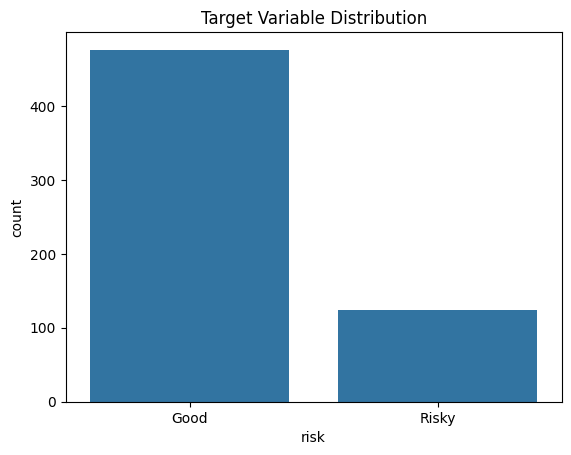

In [9]:
sns.countplot(x='risk',data=df)
plt.title('Target Variable Distribution')
plt.show()

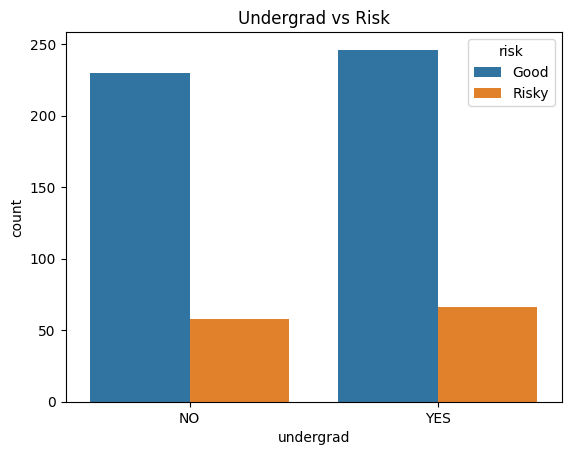

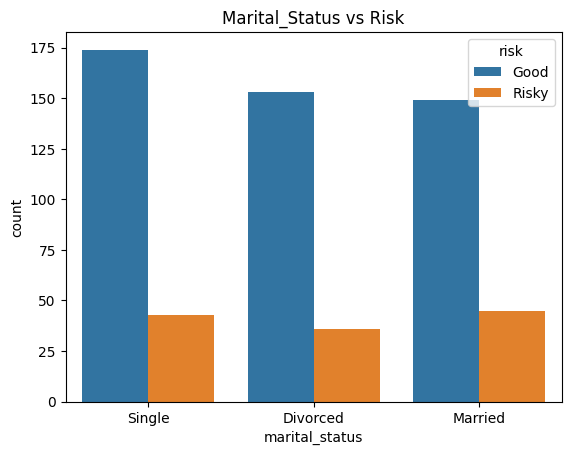

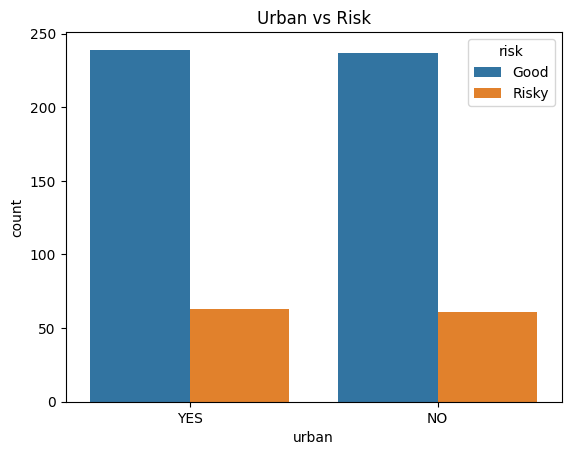

In [14]:
categorical_cols = ['undergrad','marital_status','urban']
for col in categorical_cols:
    sns.countplot(x=col,hue='risk',data=df)
    plt.title(f'{col.title()} vs Risk')
    plt.show()

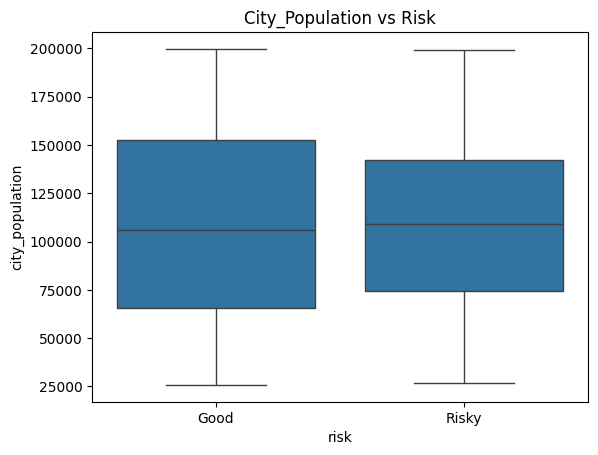

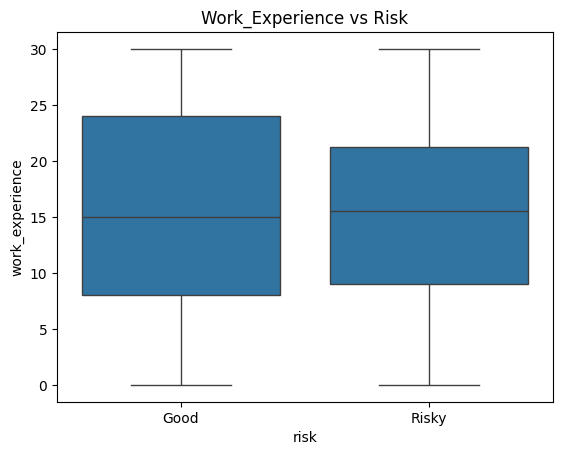

In [15]:
num_cols = ['city_population','work_experience']
for col in num_cols:
    sns.boxplot(x='risk',y=col,data=df)
    plt.title(f'{col.title()} vs Risk')
    plt.show()

In [16]:
df_encoded = pd.get_dummies(
    df,
    columns=['undergrad','marital_status','urban'],
    drop_first=True
)
df_encoded.head()

,city_population,work_experience,risk,undergrad_YES,marital_status_Married,marital_status_Single,urban_YES
0,50047,10,Good,False,False,True,True
1,134075,18,Good,True,False,False,True
2,160205,30,Good,False,True,False,True
3,193264,15,Good,True,False,True,True
4,27533,28,Good,False,True,False,False


In [17]:
X = df_encoded.drop('risk',axis=1)
y = df_encoded['risk']

In [18]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42,stratify=y)

In [48]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [50]:
y_pred = rf_model.predict(X_test)
print('Base RF')
print(classification_report(y_test,y_pred))

Base RF
              precision    recall  f1-score   support

        Good       0.79      0.94      0.86       119
       Risky       0.12      0.03      0.05        31

    accuracy                           0.75       150
   macro avg       0.46      0.49      0.45       150
weighted avg       0.65      0.75      0.69       150



In [51]:
y_prob = rf_model.predict_proba(X_test)[:,1]
y_pred_thresh = np.where(y_prob>=0.3,'Risky','Good')

print('Threshold = 0.3')
print(classification_report(y_test,y_pred_thresh))

Threshold = 0.3
              precision    recall  f1-score   support

        Good       0.75      0.70      0.72       119
       Risky       0.10      0.13      0.11        31

    accuracy                           0.58       150
   macro avg       0.43      0.41      0.42       150
weighted avg       0.62      0.58      0.60       150



In [52]:
accuracy_score(y_test,y_pred)

0.7533333333333333

In [54]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train,y_train)

rf_smote = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    random_state=42
)
rf_smote.fit(X_train_smote,y_train_smote)
y_pred_smote = rf_smote.predict(X_test)

print('SMOTE + RF')
print(classification_report(y_test,y_pred_smote))
print('Accuracy:',accuracy_score(y_test,y_pred_smote))

SMOTE + RF
              precision    recall  f1-score   support

        Good       0.76      0.58      0.66       119
       Risky       0.15      0.29      0.20        31

    accuracy                           0.52       150
   macro avg       0.46      0.44      0.43       150
weighted avg       0.63      0.52      0.56       150

Accuracy: 0.52


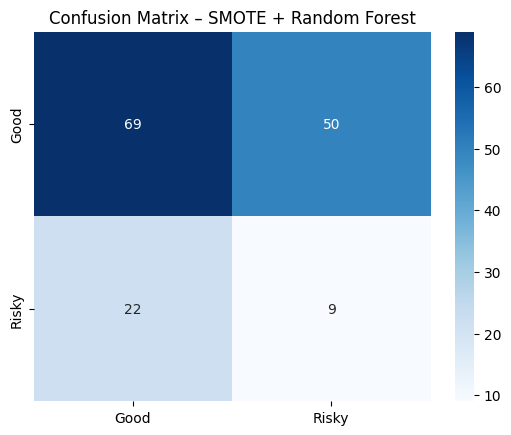

In [55]:
cm = confusion_matrix(y_test, y_pred_smote)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Good','Risky'],
            yticklabels=['Good','Risky'])
plt.title('Confusion Matrix – SMOTE + Random Forest')
plt.show()


In [56]:
feature_importance = pd.Series(
    rf_smote.feature_importances_,
    index=X.columns
).sort_values(ascending=False)
feature_importance

city_population           0.452486
work_experience           0.309484
marital_status_Single     0.073280
marital_status_Married    0.069564
urban_YES                 0.055490
undergrad_YES             0.039696
dtype: float64

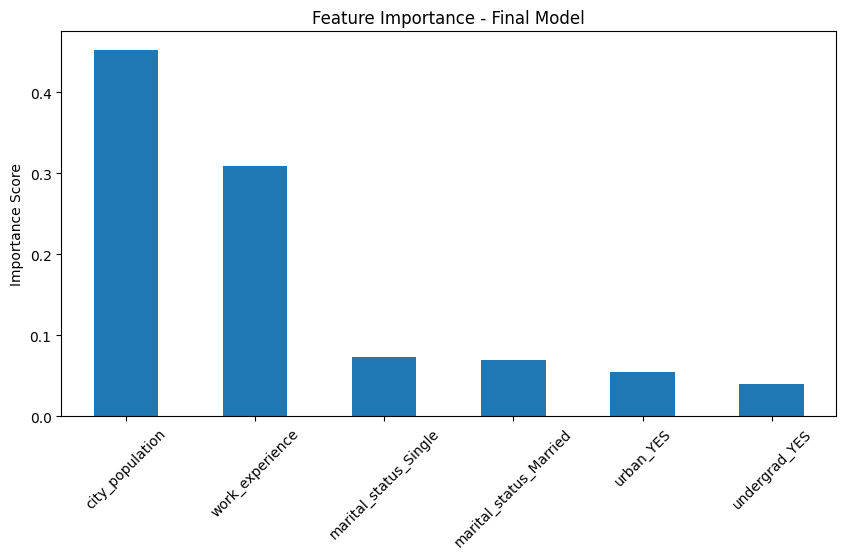

In [57]:
feature_importance.plot(kind='bar',figsize=(10,5))
plt.title('Feature Importance - Final Model')
plt.xticks(rotation=45)
plt.ylabel('Importance Score')
plt.show()